# Perform QC on H&E histopathology images

This tutorial shows how to use Squidpy to perform QC operations on histopathology images
that might be associated with your spatial omics datasets.

In [88]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
import scanpy as sc
import os
import squidpy as sq
import tifffile
import matplotlib.pyplot as plt
import spatialdata as sd
import spatialdata_plot
from spatialdata.models import Image2DModel

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

import importlib
importlib.reload(sq)


squidpy==1.6.6.dev30+g06be11cbc.d20250913


<module 'squidpy' from '/Users/tim.treis/Documents/GitHub/squidpy/src/squidpy/__init__.py'>

## Download H&E images with different focus issues

First we'll download and convert some histopathology images from the Cancer Imaging Archive. Based on [this metadata](https://www.cancerimagingarchive.net/wp-content/uploads/wsi_quality_control_result.txt) we pick the following images

| WSI-ID                                                       | VisualAssessmentComment                         |
|--------------------------------------------------------------|-------------------------------------------------|
| TCGA-HZ-8638-01Z-00-DX1.AD9F30CA-8943-493E-8603-7D1CF41056E6 | clumps. right part of the image is out of focus |
| TCGA-AP-A1DR-01Z-00-DX1.59D56F74-930F-4B0D-91D4-B3C0B4A92073 | some regions are out of focus                   |

In [ ]:
!uuid=$(curl -s -X POST "https://api.gdc.cancer.gov/files" -H "Content-Type: application/json" --data "{\"filters\": {\"op\": \"=\", \"content\": {\"field\": \"file_name\", \"value\": \"TCGA-HZ-8638-01Z-00-DX1.AD9F30CA-8943-493E-8603-7D1CF41056E6.svs\"}}, \"fields\": \"id\", \"size\": 1}" | python -c "import sys, json; print(json.load(sys.stdin)[\"data\"][\"hits\"][0][\"id\"])") && curl -L -O -J "https://api.gdc.cancer.gov/data/${uuid}"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: Failed to open the file 
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (23) Failed writing header


In [182]:
# check if sdata exists, otherwise convert svs to SpatialData zarr
if not os.path.exists("./TCGA-HZ-8638-01Z-00-DX1_sdata.zarr"):
    with tifffile.TiffFile("./TCGA-HZ-8638-01Z-00-DX1.AD9F30CA-8943-493E-8603-7D1CF41056E6.svs") as tf:    
        raw = tf.series[0].levels[0].asarray()  # full resolution
    img = Image2DModel.parse(raw.transpose(2, 1, 0), scale_factors=None)
    sdata = sd.SpatialData(images={"TCGA-HZ-8638-01Z-00-DX1": img})

    # Write to disk for efficient dask processing
    sdata.write("./TCGA-HZ-8638-01Z-00-DX1_sdata.zarr", overwrite=True)
    
sdata = sd.read_zarr("./TCGA-HZ-8638-01Z-00-DX1_sdata.zarr")
sdata

version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


SpatialData object, with associated Zarr store: /Users/tim.treis/Documents/GitHub/squidpy_notebooks/tutorials/TCGA-HZ-8638-01Z-00-DX1_sdata.zarr
└── Images
      └── 'TCGA-HZ-8638-01Z-00-DX1': DataArray[cyx] (3, 112231, 67006)
with coordinate systems:
    ▸ 'global', with elements:
        TCGA-HZ-8638-01Z-00-DX1 (Images)

## Run QC metrics
We will run our function to calculate the image sharpness now. The function operates as 
follows:

1) First, a regular grid of tiles is generated that spans the entire tissue. 
   - If `tile_size = auto`, the method calculates a tile size so that the smaller 
     dimension of the image is covered by roughly 100 square tiles. The larger dimension
     is then covered accordingly. However, the minimal tile size will always be 100 px.
   - Alternatively, a tuple of ints can be specified for the tile size.
2) Across these tiles, sharpness scores are then calculated.
3) If `detect_outliers=True`, the function will attempt to classify these tiles on 
   whether their sharpness values could be considered outliers (and therefore blurry).
4) If `detect_tissue=True`, first an attempt is made to detect which tiles cover the 
   actual specimen and which belong the background. This information is then used in 
   the background detection.
5) Finally, the sharpness metric results are used to calcualte a score for how likely 
   a tile is to be out of focus. 
    

In [183]:
sq.exp.im.qc_sharpness(
    sdata,
    image_key="TCGA-HZ-8638-01Z-00-DX1",
    scale="scale0",
    metrics=["tenengrad", "var_of_laplacian"],
    tile_size="auto",
    detect_outliers=True,
    detect_tissue=True,
    outlier_method="pvalue",
    progress=True,
)

INFO     Preparing sharpness metrics calculation.                                                                  
INFO     - Image size (x, y) is (67006, 112231), using tiles with size (x, y): (670, 670).                         
INFO     - Resulting tile grid has shape (x, y): (101, 168).                                                       

INFO     Calculating sharpness metrics.                                                                            
INFO     - Computing sharpness metric 'tenengrad'.                                                                 
[########################################] | 100% Completed | 43.21 s
INFO     - Computing sharpness metric 'var_of_laplacian'.                                                          
[########################################] | 100% Completed | 42.79 s

INFO     Detecting outlier tiles using method 'pvalue'...                                                          
INFO     - Classifying tiles as tissue vs back

INFO     Plotting 2 sharpness metrics: ['tenengrad', 'var_of_laplacian']                                           
INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' to disable this    
         behaviour.                                                                                                


/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `qc_img_TCGA-HZ-8638-01Z-00-DX1_sharpness_grid` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `qc_img_TCGA-HZ-8638-01Z-00-DX1_sharpness` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     
INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' to disable this    
         behaviour.                                                                                                


/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `qc_img_TCGA-HZ-8638-01Z-00-DX1_sharpness_grid` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `qc_img_TCGA-HZ-8638-01Z-00-DX1_sharpness` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     


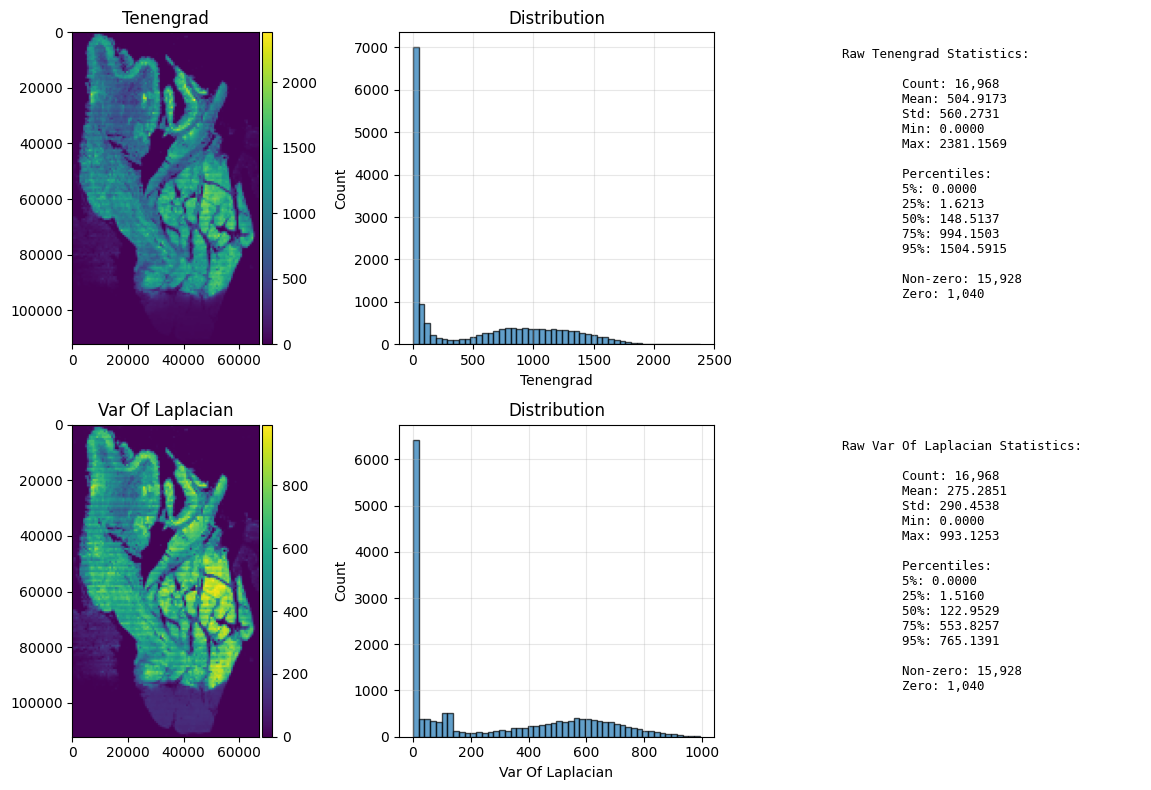

In [184]:
sq.exp.pl.qc_sharpness_metrics(
    sdata,
    image_key="TCGA-HZ-8638-01Z-00-DX1",
)

INFO     Rasterizing image for faster rendering.                                                                   


/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `qc_img_TCGA-HZ-8638-01Z-00-DX1_sharpness_grid` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `qc_img_TCGA-HZ-8638-01Z-00-DX1_sharpness` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata_plot/pl/utils.py:800: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' to disable this    
         behaviour.                                                                                                


/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `qc_img_TCGA-HZ-8638-01Z-00-DX1_sharpness_grid` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `qc_img_TCGA-HZ-8638-01Z-00-DX1_sharpness` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     
INFO     Rasterizing image for faster rendering.                                                                   


/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `qc_img_TCGA-HZ-8638-01Z-00-DX1_sharpness_grid` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `qc_img_TCGA-HZ-8638-01Z-00-DX1_sharpness` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata_plot/pl/utils.py:800: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


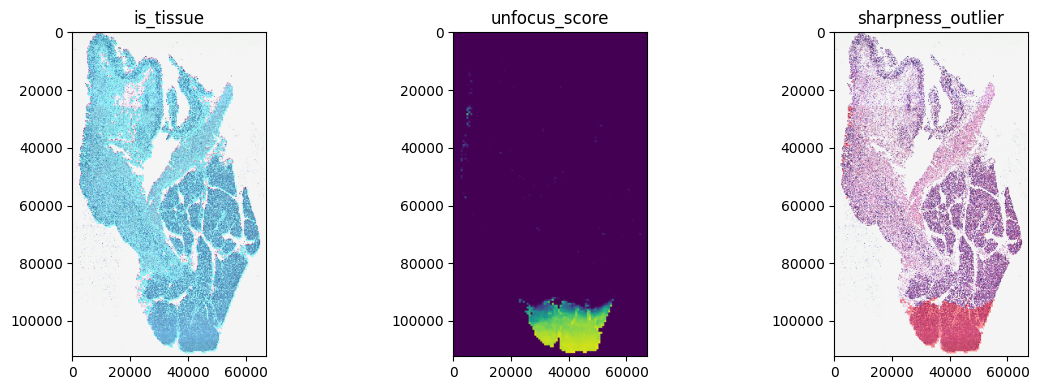

In [185]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))
axs = axs.flatten()

(
    sdata
    .pl.render_images("TCGA-HZ-8638-01Z-00-DX1")
    .pl.render_shapes("qc_img_TCGA-HZ-8638-01Z-00-DX1_sharpness_grid", groups="True", palette="cyan", method="matplotlib", fill_alpha=0.4, color="is_tissue")
    .pl.show(ax=axs[0], title="is_tissue", legend_loc=None)
)

(
    sdata
    .pl.render_shapes("qc_img_TCGA-HZ-8638-01Z-00-DX1_sharpness_grid", color="unfocus_score")
    .pl.show(ax=axs[1], title="unfocus_score", colorbar=False)
)

(
    sdata
    .pl.render_images("TCGA-HZ-8638-01Z-00-DX1")
    .pl.render_shapes("qc_img_TCGA-HZ-8638-01Z-00-DX1_sharpness_grid", groups="True", palette="red", method="matplotlib", fill_alpha=0.4, color="sharpness_outlier")
    .pl.show(ax=axs[2], title="sharpness_outlier", legend_loc=None)
)

plt.tight_layout()

Our score supports the pathologist annotation from the TCGA file. Let's repeat this for another sample.

In [7]:
!uuid=$(curl -s -X POST "https://api.gdc.cancer.gov/files" -H "Content-Type: application/json" --data "{\"filters\": {\"op\": \"=\", \"content\": {\"field\": \"file_name\", \"value\": \"TCGA-AP-A1DR-01Z-00-DX1.59D56F74-930F-4B0D-91D4-B3C0B4A92073.svs\"}}, \"fields\": \"id\", \"size\": 1}" | python -c "import sys, json; print(json.load(sys.stdin)[\"data\"][\"hits\"][0][\"id\"])") && curl -L -O -J "https://api.gdc.cancer.gov/data/${uuid}"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  270M  100  270M    0     0  5801k      0  0:00:47  0:00:47 --:--:-- 5909k  0  0:00:52  0:00:17  0:00:35 5826k  0:00:33  0:00:15 5756k:00:48  0:00:35  0:00:13 6066k3 6055k


In [177]:
# check if sdata exists, otherwise convert svs to SpatialData zarr
if not os.path.exists("./TCGA-AP-A1DR-01Z-00-DX1_sdata.zarr"):
    with tifffile.TiffFile("./TCGA-AP-A1DR-01Z-00-DX1.59D56F74-930F-4B0D-91D4-B3C0B4A92073.svs") as tf:    
        raw = tf.series[0].levels[0].asarray()  # full resolution
    img = Image2DModel.parse(raw.transpose(2, 1, 0), scale_factors=None)
    sdata = sd.SpatialData(images={"TCGA-AP-A1DR-01Z-00-DX1": img})

    # Write to disk for efficient dask processing
    sdata.write("./TCGA-AP-A1DR-01Z-00-DX1_sdata.zarr", overwrite=True)
    
sdata = sd.read_zarr("./TCGA-AP-A1DR-01Z-00-DX1_sdata.zarr")
sdata

version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


SpatialData object, with associated Zarr store: /Users/tim.treis/Documents/GitHub/squidpy_notebooks/tutorials/TCGA-AP-A1DR-01Z-00-DX1_sdata.zarr
└── Images
      └── 'TCGA-AP-A1DR-01Z-00-DX1': DataArray[cyx] (3, 47935, 37570)
with coordinate systems:
    ▸ 'global', with elements:
        TCGA-AP-A1DR-01Z-00-DX1 (Images)

In [178]:
sq.exp.im.qc_sharpness(
    sdata,
    image_key="TCGA-AP-A1DR-01Z-00-DX1",
    scale="scale0",
    metrics=["tenengrad", "var_of_laplacian"],
    tile_size="auto",
    detect_outliers=True,
    detect_tissue=True,
    outlier_method="pvalue",
    progress=True,
)

INFO     Preparing sharpness metrics calculation.                                                                  
INFO     - Image size (x, y) is (37570, 47935), using tiles with size (x, y): (375, 375).                          
INFO     - Resulting tile grid has shape (x, y): (101, 128).                                                       

INFO     Calculating sharpness metrics.                                                                            
INFO     - Computing sharpness metric 'tenengrad'.                                                                 
[########################################] | 100% Completed | 17.29 s
INFO     - Computing sharpness metric 'var_of_laplacian'.                                                          
[########################################] | 100% Completed | 16.14 s

INFO     Detecting outlier tiles using method 'pvalue'...                                                          
INFO     - Classifying tiles as tissue vs back

INFO     Plotting 2 sharpness metrics: ['tenengrad', 'var_of_laplacian']                                           
INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' to disable this    
         behaviour.                                                                                                


/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `qc_img_TCGA-AP-A1DR-01Z-00-DX1_sharpness_grid` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `qc_img_TCGA-AP-A1DR-01Z-00-DX1_sharpness` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     
INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' to disable this    
         behaviour.                                                                                                


/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `qc_img_TCGA-AP-A1DR-01Z-00-DX1_sharpness_grid` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `qc_img_TCGA-AP-A1DR-01Z-00-DX1_sharpness` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     


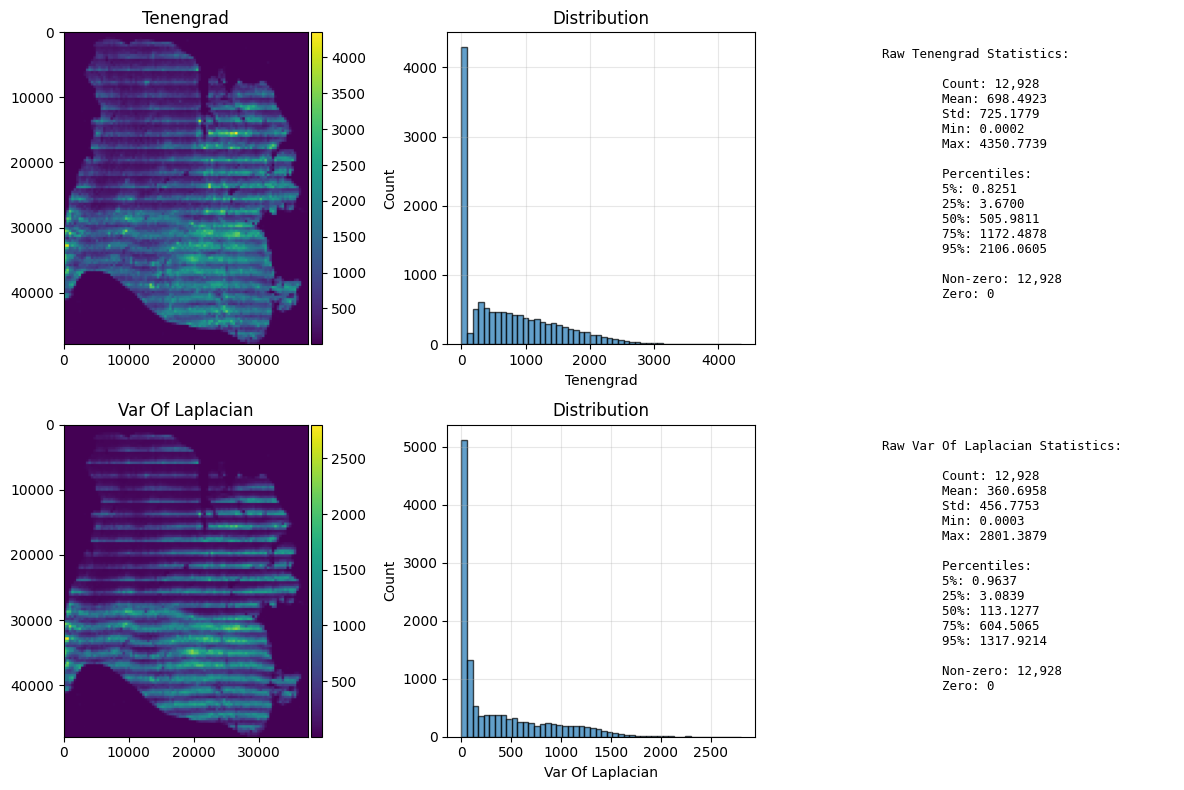

In [180]:
sq.exp.pl.qc_sharpness_metrics(
    sdata,
    image_key="TCGA-AP-A1DR-01Z-00-DX1",
)

INFO     Rasterizing image for faster rendering.                                                                   


/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `qc_img_TCGA-AP-A1DR-01Z-00-DX1_sharpness_grid` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `qc_img_TCGA-AP-A1DR-01Z-00-DX1_sharpness` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata_plot/pl/utils.py:800: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' to disable this    
         behaviour.                                                                                                


/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `qc_img_TCGA-AP-A1DR-01Z-00-DX1_sharpness_grid` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `qc_img_TCGA-AP-A1DR-01Z-00-DX1_sharpness` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     
INFO     Rasterizing image for faster rendering.                                                                   


/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `qc_img_TCGA-AP-A1DR-01Z-00-DX1_sharpness_grid` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `qc_img_TCGA-AP-A1DR-01Z-00-DX1_sharpness` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata_plot/pl/utils.py:800: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


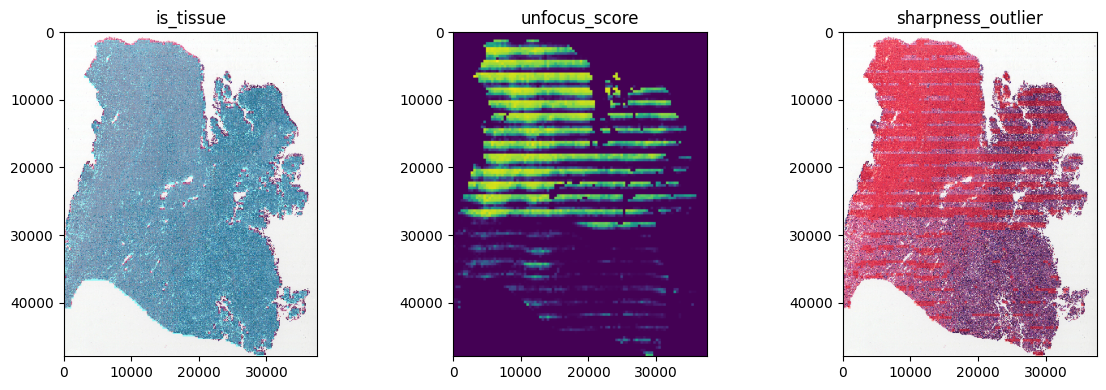

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))
axs = axs.flatten()

(
    sdata
    .pl.render_images("TCGA-AP-A1DR-01Z-00-DX1")
    .pl.render_shapes("qc_img_TCGA-AP-A1DR-01Z-00-DX1_sharpness_grid", groups="True", palette="cyan", method="matplotlib", fill_alpha=0.4, color="is_tissue")
    .pl.show(ax=axs[0], title="is_tissue", legend_loc=None)
)

(
    sdata
    .pl.render_shapes("qc_img_TCGA-AP-A1DR-01Z-00-DX1_sharpness_grid", color="unfocus_score")
    .pl.show(ax=axs[1], title="unfocus_score", colorbar=False)
)

(
    sdata
    .pl.render_images("TCGA-AP-A1DR-01Z-00-DX1")
    .pl.render_shapes("qc_img_TCGA-AP-A1DR-01Z-00-DX1_sharpness_grid", groups="True", palette="red", method="matplotlib", fill_alpha=0.4, color="sharpness_outlier")
    .pl.show(ax=axs[2], title="sharpness_outlier", legend_loc=None)
)

plt.tight_layout()

In comparison, let's run the metric on a toy dataset where we don't expect fundamental sharpness issues

In [3]:
sdata = sq.datasets.visium_hne_sdata()
sq.exp.im.qc_sharpness(
    sdata,
    image_key="hne",
)

/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


INFO     Preparing sharpness metrics calculation.                                                                  
INFO     - Image size (x, y) is (11291, 11757), using tiles with size (x, y): (112, 112).                          
INFO     - Resulting tile grid has shape (x, y): (101, 105).                                                       

INFO     Calculating sharpness metrics.                                                                            
INFO     - Computing sharpness metric 'tenengrad'.                                                                 
[########################################] | 100% Completed | 10.09 s
INFO     - Computing sharpness metric 'var_of_laplacian'.                                                          
[########################################] | 100% Completed | 10.41 s

INFO     Detecting outlier tiles using method 'pvalue'...                                                          
INFO     - Classifying tiles as tissue vs back

INFO     Plotting 2 sharpness metrics: ['tenengrad', 'var_of_laplacian']                                           
INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' to disable this    
         behaviour.                                                                                                


/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `qc_img_hne_sharpness_grid` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `qc_img_hne_sharpness` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     
INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' to disable this    
         behaviour.                                                                                                


/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `qc_img_hne_sharpness_grid` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `qc_img_hne_sharpness` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     


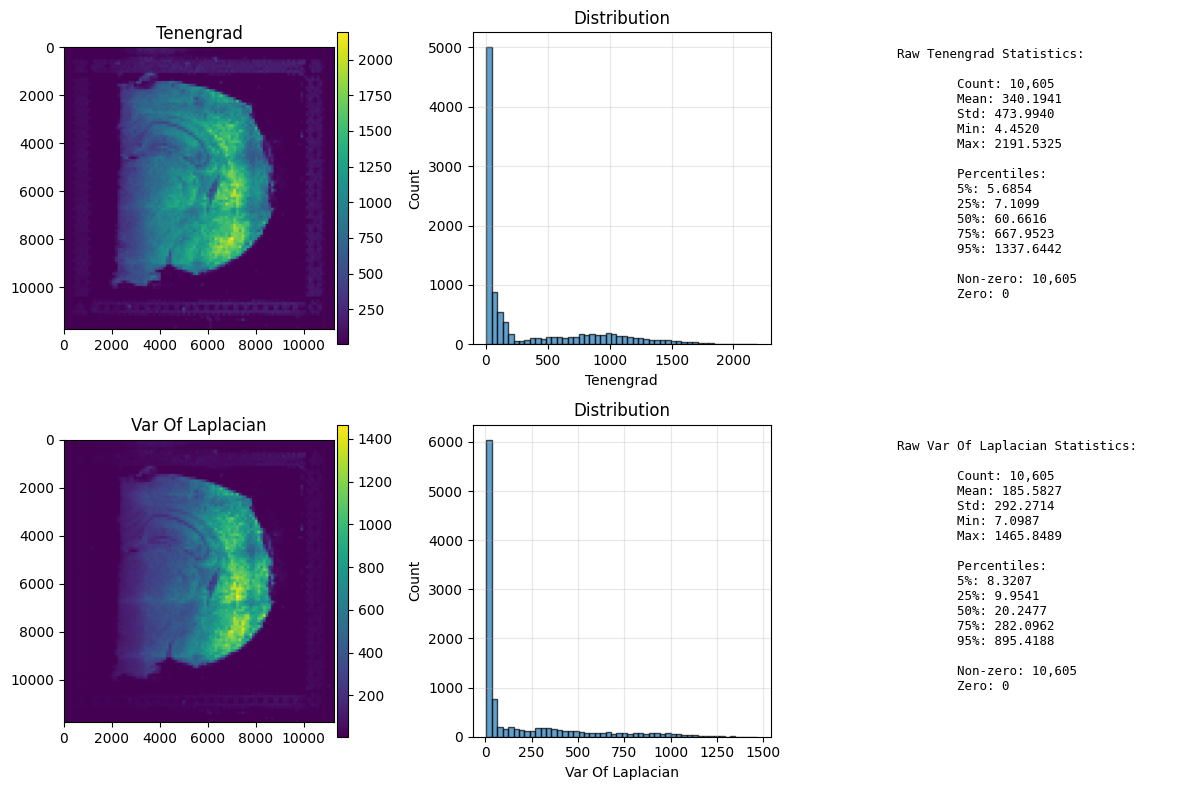

In [144]:
sq.exp.pl.qc_sharpness_metrics(
    sdata,
    image_key="hne",
)

/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata_plot/pl/utils.py:800: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' to disable this    
         behaviour.                                                                                                
INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     


/Users/tim.treis/Documents/GitHub/squidpy/.pixi/envs/dev-py313/lib/python3.13/site-packages/spatialdata_plot/pl/utils.py:800: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


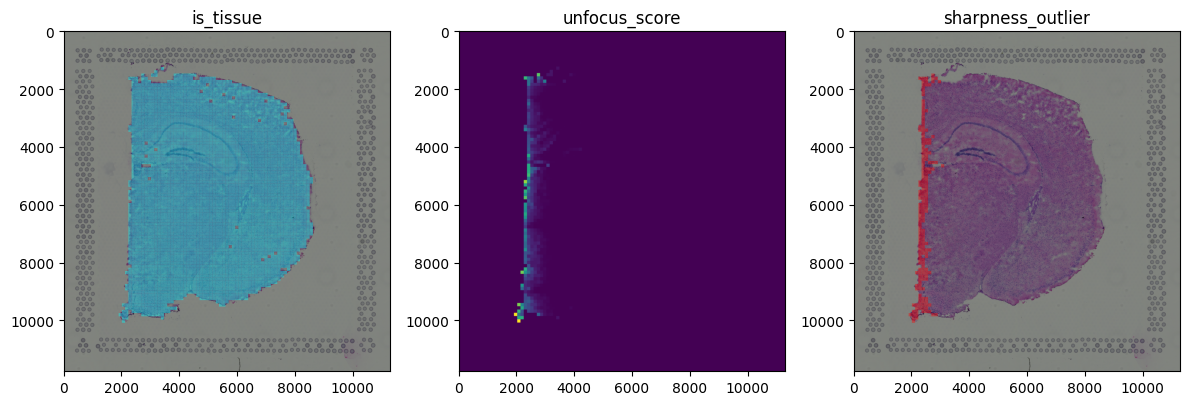

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))
axs = axs.flatten()

(
    sdata
    .pl.render_images("hne", scale="scale3")
    .pl.render_shapes("qc_img_hne_sharpness_grid", groups="True", palette="cyan", method="matplotlib", fill_alpha=0.4, color="is_tissue")
    .pl.show(ax=axs[0], title="is_tissue", legend_loc=None)
)

(
    sdata
    .pl.render_shapes("qc_img_hne_sharpness_grid", color="unfocus_score")
    .pl.show(ax=axs[1], title="unfocus_score", colorbar=False)
)

(
    sdata
    .pl.render_images("hne", scale="scale3")
    .pl.render_shapes("qc_img_hne_sharpness_grid", groups="True", palette="red", method="matplotlib", fill_alpha=0.4, color="sharpness_outlier")
    .pl.show(ax=axs[2], title="sharpness_outlier", legend_loc=None)
)

plt.tight_layout()

Surprisingly, even here we see a slightly blurry edge which could indicate a slight uplift of the sample.